In [27]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.utils import class_weight
from pyvi import ViTokenizer
from sklearn.metrics import confusion_matrix,classification_report
from collections import Counter
from sklearn.utils import resample
from utils import load_checkpoint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
from model import AttentionModel
from dataset import TextDataset

In [76]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Load data

In [30]:
data_path = '../data'
model_path = '../model'

In [31]:
df_ = pd.read_csv(os.path.join(r'E:\NLP\Vietnamese-Text-Classification-master\data\test.csv'))

In [32]:
with open(r'E:\NLP\Vietnamese-Text-Classification-master\data\vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    stop_words = file.read().splitlines()
print(stop_words)
df_['Contents'] = df_['Contents'].apply(lambda x: '' if isinstance(x, float) else x)
df_['Contents'] = df_['Contents'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

['a lô', 'a ha', 'ai', 'ai ai', 'ai nấy', 'ai đó', 'alô', 'amen', 'anh', 'anh ấy', 'ba', 'ba ba', 'ba bản', 'ba cùng', 'ba họ', 'ba ngày', 'ba ngôi', 'ba tăng', 'bao giờ', 'bao lâu', 'bao nhiêu', 'bao nả', 'bay biến', 'biết', 'biết bao', 'biết bao nhiêu', 'biết chắc', 'biết chừng nào', 'biết mình', 'biết mấy', 'biết thế', 'biết trước', 'biết việc', 'biết đâu', 'biết đâu chừng', 'biết đâu đấy', 'biết được', 'buổi', 'buổi làm', 'buổi mới', 'buổi ngày', 'buổi sớm', 'bà', 'bà ấy', 'bài', 'bài bác', 'bài bỏ', 'bài cái', 'bác', 'bán', 'bán cấp', 'bán dạ', 'bán thế', 'bây bẩy', 'bây chừ', 'bây giờ', 'bây nhiêu', 'bèn', 'béng', 'bên', 'bên bị', 'bên có', 'bên cạnh', 'bông', 'bước', 'bước khỏi', 'bước tới', 'bước đi', 'bạn', 'bản', 'bản bộ', 'bản riêng', 'bản thân', 'bản ý', 'bất chợt', 'bất cứ', 'bất giác', 'bất kì', 'bất kể', 'bất kỳ', 'bất luận', 'bất ngờ', 'bất nhược', 'bất quá', 'bất quá chỉ', 'bất thình lình', 'bất tử', 'bất đồ', 'bấy', 'bấy chầy', 'bấy chừ', 'bấy giờ', 'bấy lâu', 'bấy lâ

In [33]:
df_.head(10)

,URL,Title,Summary,Contents,Date,Author(s),Category,Tags
0,https://laodong.vn/thoi-su/ha-noi-ho-tro-hon-4...,"Hà Nội hỗ trợ hơn 4,5 tỉ đồng cho các tỉnh phí...","Trước tình hình mưa lớn gây lũ lụt, lũ ống, lũ...","đó, ảnh hưởng tỉnh Sơn La, Yên Bái, tỉnh Lai C...","Thứ ba, 08/08/2017 11:12 (GMT+7)",L.HOA,Thời sự,['Hà Nội']
1,https://laodong.vn/kinh-te/kien-giang-xuc-tien...,Kiên Giang: Xúc tiến thương mại qua đường hàng...,"Kiên Giang - Chiều ngày 14.1, UBND tỉnh tổ chứ...","Thông hội nghị biết, 2019, tổng lượt du lịch K...","Thứ sáu, 14/01/2022 21:21 (GMT+7)",Hoàng Dung,Kinh doanh,['Kiên Giang']
2,https://laodong.vn/bong-da/xem-truc-tiep-tphcm...,Xem trực tiếp TP.HCM vs Sài Gòn vòng 4 V.Leagu...,Báo Lao Động xin gửi tới quý độc giả link xem ...,"lượt trận vòng 4, bảng xếp hạng V.League 2020 ...","Thứ sáu, 12/06/2020 15:19 (GMT+7)",Bảo Bình,Thể thao,"['TPHCM', 'TP.HCM', 'V.League 2020', 'trực tiế..."
3,https://laodong.vn/suc-khoe/nhung-loi-chuc-nga...,Những lời chúc ngày Thầy thuốc Việt Nam hay nhất,Những lời chúc ngày 27.2 hay và ý nghĩa để dàn...,"27.2.1955, Chủ tịch Hồ Chí Minh đích thân viết...","Thứ tư, 27/02/2019 10:17 (GMT+7)",Thảo Anh (TH),Sức khỏe,"['Lời chúc hay', 'Ngày Thầy thuốc Việt Nam', '..."
4,https://laodong.vn/phap-luat/tphcm-de-nghi-xu-...,TPHCM: Đề nghị xử lý nghiêm vụ trật tự đô thị ...,UBND quận Bình Tân (TPHCM) đã ra văn bản đề ng...,"Chiều 11.5, trao đổi PV Lao Động, Nguyễn Gia T...","Thứ sáu, 11/05/2018 17:27 (GMT+7)",M.Q,Pháp luật,"['TPHCM', 'Xử lý nghiêm', 'Lấn chiếm lòng lề đ..."
5,https://laodong.vn/dien-dan/chien-si-pccc-noi-...,"Chiến sĩ PCCC nói dối để cứu người, nữ thực tậ...",Chiến sĩ PCCC đã phải nói dối để trấn an người...,"đó, thực tập sinh Phan Thị Hiên (21 tuổi, sinh...","Thứ hai, 26/03/2018 09:00 (GMT+7)",Thẩm Hồng Thụy,Diễn đàn,"['Nữ thực tập sinh bị bắt quỳ gối', 'Nữ thực t..."
6,https://laodong.vn/xa-hoi/nhung-chieu-tro-lua-...,"Những chiêu trò lừa đảo, chiếm đoạt tiền phổ b...",Lợi dụng thời điểm cận Tết người dân có nhiều ...,Thủ đoạn cắp thông ngân hàng Lê Hoàng Minh – T...,"Chủ nhật, 12/01/2020 07:33 (GMT+7)",Trần Khanh,Xã hội,"['Chiếm đoạt tài sản', 'TẾT', 'Lừa đảo qua mạn..."
7,https://laodong.vn/bong-da-quoc-te/tottenham-v...,Tottenham vs Dortmund: Chờ đợi màn đôi công má...,"Vào lúc 3h rạng sáng 14.2, Tottenham sẽ tiếp đ...","Tottenham phong độ đây, 3 trận Premier League ...","Thứ tư, 13/02/2019 12:23 (GMT+7)",Văn Thượng,Thể thao,"['Tottenham', 'Inter Milan', 'Champios League'..."
8,https://laodong.vn/phap-luat/lanh-dao-lam-truo...,Lãnh đạo lâm trường bị đối tượng vi phạm dùng ...,"Ngày 17.10, Lâm trường Đồng Hới (Quảng Bình) c...","đó, 9h30 16.10, thực hiện nhiệm vụ tuần tra bả...","Thứ tư, 17/10/2018 08:15 (GMT+7)",LÊ PHI LONG,Pháp luật,"['Kiểm lâm', 'Cấp cứu', 'Tấn công']"
9,https://laodong.vn/doanh-nghiep-doanh-nhan/goo...,"Google và Amazon giải quyết mâu thuẫn, đưa You...",Amazon (NASDAQ: AMZN) và Google (NASDAQ: GOOGL...,Google YouTube trở thiết Fire TV Amazon 2019. ...,"Chủ nhật, 21/04/2019 07:07 (GMT+7)",Lê Minh,Kinh doanh,"['Google', 'Amazon', 'Fire TV', 'Fire TV Editi..."


In [34]:
drop_columns=['Date','Author(s)','Tags','URL']
train_data = df_.drop(columns=drop_columns)
train_data.head(10)

,Title,Summary,Contents,Category
0,"Hà Nội hỗ trợ hơn 4,5 tỉ đồng cho các tỉnh phí...","Trước tình hình mưa lớn gây lũ lụt, lũ ống, lũ...","đó, ảnh hưởng tỉnh Sơn La, Yên Bái, tỉnh Lai C...",Thời sự
1,Kiên Giang: Xúc tiến thương mại qua đường hàng...,"Kiên Giang - Chiều ngày 14.1, UBND tỉnh tổ chứ...","Thông hội nghị biết, 2019, tổng lượt du lịch K...",Kinh doanh
2,Xem trực tiếp TP.HCM vs Sài Gòn vòng 4 V.Leagu...,Báo Lao Động xin gửi tới quý độc giả link xem ...,"lượt trận vòng 4, bảng xếp hạng V.League 2020 ...",Thể thao
3,Những lời chúc ngày Thầy thuốc Việt Nam hay nhất,Những lời chúc ngày 27.2 hay và ý nghĩa để dàn...,"27.2.1955, Chủ tịch Hồ Chí Minh đích thân viết...",Sức khỏe
4,TPHCM: Đề nghị xử lý nghiêm vụ trật tự đô thị ...,UBND quận Bình Tân (TPHCM) đã ra văn bản đề ng...,"Chiều 11.5, trao đổi PV Lao Động, Nguyễn Gia T...",Pháp luật
5,"Chiến sĩ PCCC nói dối để cứu người, nữ thực tậ...",Chiến sĩ PCCC đã phải nói dối để trấn an người...,"đó, thực tập sinh Phan Thị Hiên (21 tuổi, sinh...",Diễn đàn
6,"Những chiêu trò lừa đảo, chiếm đoạt tiền phổ b...",Lợi dụng thời điểm cận Tết người dân có nhiều ...,Thủ đoạn cắp thông ngân hàng Lê Hoàng Minh – T...,Xã hội
7,Tottenham vs Dortmund: Chờ đợi màn đôi công má...,"Vào lúc 3h rạng sáng 14.2, Tottenham sẽ tiếp đ...","Tottenham phong độ đây, 3 trận Premier League ...",Thể thao
8,Lãnh đạo lâm trường bị đối tượng vi phạm dùng ...,"Ngày 17.10, Lâm trường Đồng Hới (Quảng Bình) c...","đó, 9h30 16.10, thực hiện nhiệm vụ tuần tra bả...",Pháp luật
9,"Google và Amazon giải quyết mâu thuẫn, đưa You...",Amazon (NASDAQ: AMZN) và Google (NASDAQ: GOOGL...,Google YouTube trở thiết Fire TV Amazon 2019. ...,Kinh doanh


In [35]:
def display_missing(df,features_columns):
    n_rows=df.shape[0]
    for col in features_columns:
        missing_count=df[col].isnull().sum()
        if missing_count>0:
            print(f"{col} has {missing_count} missing values")
column_names = train_data.columns
print("Train:",display_missing(train_data,column_names))

Summary has 5 missing values
Train: None


In [36]:
train_data = train_data.dropna(subset=['Contents'])
train_data = train_data.dropna(subset=['Summary'])

In [37]:
print("Train:",display_missing(train_data,column_names))

Train: None


In [38]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_data['Category'] = label_encoder.fit_transform(train_data['Category'])

In [39]:
train_data.head(10)

,Title,Summary,Contents,Category
0,"Hà Nội hỗ trợ hơn 4,5 tỉ đồng cho các tỉnh phí...","Trước tình hình mưa lớn gây lũ lụt, lũ ống, lũ...","đó, ảnh hưởng tỉnh Sơn La, Yên Bái, tỉnh Lai C...",19
1,Kiên Giang: Xúc tiến thương mại qua đường hàng...,"Kiên Giang - Chiều ngày 14.1, UBND tỉnh tổ chứ...","Thông hội nghị biết, 2019, tổng lượt du lịch K...",7
2,Xem trực tiếp TP.HCM vs Sài Gòn vòng 4 V.Leagu...,Báo Lao Động xin gửi tới quý độc giả link xem ...,"lượt trận vòng 4, bảng xếp hạng V.League 2020 ...",18
3,Những lời chúc ngày Thầy thuốc Việt Nam hay nhất,Những lời chúc ngày 27.2 hay và ý nghĩa để dàn...,"27.2.1955, Chủ tịch Hồ Chí Minh đích thân viết...",14
4,TPHCM: Đề nghị xử lý nghiêm vụ trật tự đô thị ...,UBND quận Bình Tân (TPHCM) đã ra văn bản đề ng...,"Chiều 11.5, trao đổi PV Lao Động, Nguyễn Gia T...",12
5,"Chiến sĩ PCCC nói dối để cứu người, nữ thực tậ...",Chiến sĩ PCCC đã phải nói dối để trấn an người...,"đó, thực tập sinh Phan Thị Hiên (21 tuổi, sinh...",4
6,"Những chiêu trò lừa đảo, chiếm đoạt tiền phổ b...",Lợi dụng thời điểm cận Tết người dân có nhiều ...,Thủ đoạn cắp thông ngân hàng Lê Hoàng Minh – T...,26
7,Tottenham vs Dortmund: Chờ đợi màn đôi công má...,"Vào lúc 3h rạng sáng 14.2, Tottenham sẽ tiếp đ...","Tottenham phong độ đây, 3 trận Premier League ...",18
8,Lãnh đạo lâm trường bị đối tượng vi phạm dùng ...,"Ngày 17.10, Lâm trường Đồng Hới (Quảng Bình) c...","đó, 9h30 16.10, thực hiện nhiệm vụ tuần tra bả...",12
9,"Google và Amazon giải quyết mâu thuẫn, đưa You...",Amazon (NASDAQ: AMZN) và Google (NASDAQ: GOOGL...,Google YouTube trở thiết Fire TV Amazon 2019. ...,7


In [40]:
question  = train_data

In [41]:
question['length'] = [len(item) for item in list(question['Contents'])]
question['num_word'] = [len(item.split(' ')) for item in list(question['Contents'])]

In [42]:
print(question)

                                                  Title  \
0     Hà Nội hỗ trợ hơn 4,5 tỉ đồng cho các tỉnh phí...   
1     Kiên Giang: Xúc tiến thương mại qua đường hàng...   
2     Xem trực tiếp TP.HCM vs Sài Gòn vòng 4 V.Leagu...   
3      Những lời chúc ngày Thầy thuốc Việt Nam hay nhất   
4     TPHCM: Đề nghị xử lý nghiêm vụ trật tự đô thị ...   
...                                                 ...   
4995  Nguyên chủ tịch xã bị bắt vì cấp đất cho người...   
4996  Thêm một trường đại học cho sinh viên đến trườ...   
4997  Khu nhà ở công nhân thành điểm nóng lây COVID-...   
4998     Truy đuổi 100km bắt đối tượng tông xe vào CSGT   
4999  Trung Quốc công bố loạt ảnh khoa học đầu tiên ...   

                                                Summary  \
0     Trước tình hình mưa lớn gây lũ lụt, lũ ống, lũ...   
1     Kiên Giang - Chiều ngày 14.1, UBND tỉnh tổ chứ...   
2     Báo Lao Động xin gửi tới quý độc giả link xem ...   
3     Những lời chúc ngày 27.2 hay và ý nghĩa để dàn...

In [43]:
np.mean(question['num_word'])

323.4632632632633

(array([4.716e+03, 2.570e+02, 1.000e+01, 3.000e+00, 5.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([1.0000e+00, 6.3920e+02, 1.2774e+03, 1.9156e+03, 2.5538e+03,
        3.1920e+03, 3.8302e+03, 4.4684e+03, 5.1066e+03, 5.7448e+03,
        6.3830e+03]),
 <BarContainer object of 10 artists>)

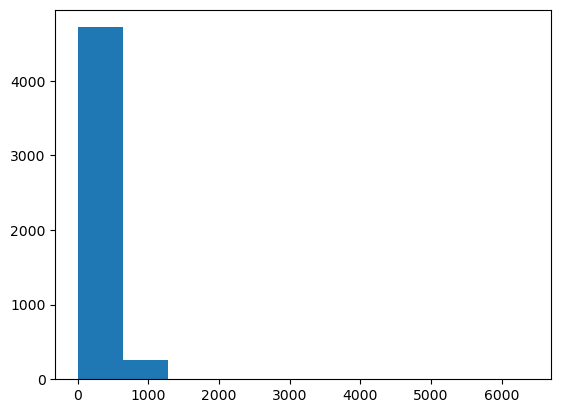

In [44]:
plt.hist(list(question['num_word']), bins = 10)

In [45]:
def tokenize(text):
    list_token = ViTokenizer.tokenize(text)
    return list_token.split(' ')

In [46]:
counts = Counter()
for index, row in question.iterrows():
    counts.update(tokenize(row['Contents']))

In [47]:
print(counts.items())

dict_items([('đó', 4974), (',', 135958), ('ảnh_hưởng', 1053), ('tỉnh', 5167), ('Sơn_La', 134), ('Yên_Bái', 98), ('Lai_Châu', 52), ('Bắc_Kạn', 31), ('Bằng', 50), ('Điện_Biên', 113), ('Lào_Cai', 111), ('xảy', 1304), ('vụ', 1783), ('sạt_lở', 152), ('nghiêm_trọng', 313), ('chết', 417), ('tích', 113), ('thương', 354), (';', 6332), ('công_trình', 565), ('cửa', 410), ('hoa_màu', 21), ('thiệt_hại', 334), ('.', 72736), ('kịp_thời', 511), ('hỗ_trợ', 1905), ('nhân_dân', 706), ('trực_tiếp', 1054), ('thiên_tai', 175), ('ra', 1373), ('khắc_phục', 367), ('khăn', 1571), ('ổn_định', 561), ('sống', 1262), ('trực', 574), ('Thành_ủy', 135), ('Hội_đồng', 471), ('Ủy_ban', 421), ('Mặt_trận', 54), ('Tổ_quốc', 119), ('Việt_Nam', 4920), ('thành_phố', 1687), ('Hà_Nội', 2871), ('quyết_định', 1152), ('Bắc', 352), ('hậu', 274), ('mưa_lũ', 80), ('gia_đình', 1637), ('nạn_nhân', 287), ('Cụ_thể', 566), (':', 7852), ('Hỗ_trợ', 98), ('nề', 101), ('Sơn_La_Yên_Bái', 1), ('1', 4261), ('tỉ', 1652), ('đồng', 4698), ('500', 19

In [48]:
from collections import Counter
with open("file.txt", 'w', encoding='utf-8') as f:
    for key, value in counts.items():
        f.write(f"{key}: {value},")

In [49]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 59843
num_words after: 28452


In [50]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [51]:
def encode_sentence(text, vocab2index, N=75):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
#     print(len(enc1))
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
#     print(len(encoded))
    return [encoded]
#     return encoded, length

In [52]:
print(words)

['', 'UNK', 'đó', ',', 'ảnh_hưởng', 'tỉnh', 'Sơn_La', 'Yên_Bái', 'Lai_Châu', 'Bắc_Kạn', 'Bằng', 'Điện_Biên', 'Lào_Cai', 'xảy', 'vụ', 'sạt_lở', 'nghiêm_trọng', 'chết', 'tích', 'thương', ';', 'công_trình', 'cửa', 'hoa_màu', 'thiệt_hại', '.', 'kịp_thời', 'hỗ_trợ', 'nhân_dân', 'trực_tiếp', 'thiên_tai', 'ra', 'khắc_phục', 'khăn', 'ổn_định', 'sống', 'trực', 'Thành_ủy', 'Hội_đồng', 'Ủy_ban', 'Mặt_trận', 'Tổ_quốc', 'Việt_Nam', 'thành_phố', 'Hà_Nội', 'quyết_định', 'Bắc', 'hậu', 'mưa_lũ', 'gia_đình', 'nạn_nhân', 'Cụ_thể', ':', 'Hỗ_trợ', 'nề', '1', 'tỉ', 'đồng', '500', 'triệu', 'địa_phương', 'nêu', 'trên', '10', '5', 'Tiền', 'trích', 'Quỹ', 'Cứu_trợ', 'Thông', 'hội_nghị', 'biết', '2019', 'tổng_lượt', 'du_lịch', 'Kiên_Giang', '8,7', 'lượt', 'khách', '13,8', '%', '2018', 'Tổng_doanh_thu', 'hoạt_động', '2020', 'dịch_bệnh', 'COVID', '-', '19', '5,2', '40', 'doanh_thu', '2021', 'đón', '3,1', 'tham_quan', '44,7', 'kế_hoạch', '41,8', 'kỳ', 'quốc_tế', 'ước', '3.500', '98', '25,2', 'Giám_đốc', 'Sở', 'Du_l

In [53]:
N = 4000
question['encoded'] = question['Contents'].apply(lambda x: np.array(encode_sentence(x,vocab2index,N)))
question.head()

,Title,Summary,Contents,Category,length,num_word,encoded
0,"Hà Nội hỗ trợ hơn 4,5 tỉ đồng cho các tỉnh phí...","Trước tình hình mưa lớn gây lũ lụt, lũ ống, lũ...","đó, ảnh hưởng tỉnh Sơn La, Yên Bái, tỉnh Lai C...",19,734,159,"[[2, 3, 4, 5, 6, 3, 7, 3, 5, 8, 3, 9, 3, 10, 3..."
1,Kiên Giang: Xúc tiến thương mại qua đường hàng...,"Kiên Giang - Chiều ngày 14.1, UBND tỉnh tổ chứ...","Thông hội nghị biết, 2019, tổng lượt du lịch K...",7,2695,545,"[[69, 70, 71, 3, 72, 3, 73, 74, 75, 76, 59, 77..."
2,Xem trực tiếp TP.HCM vs Sài Gòn vòng 4 V.Leagu...,Báo Lao Động xin gửi tới quý độc giả link xem ...,"lượt trận vòng 4, bảng xếp hạng V.League 2020 ...",18,668,142,"[[77, 264, 265, 266, 3, 267, 268, 269, 84, 270..."
3,Những lời chúc ngày Thầy thuốc Việt Nam hay nhất,Những lời chúc ngày 27.2 hay và ý nghĩa để dàn...,"27.2.1955, Chủ tịch Hồ Chí Minh đích thân viết...",14,1594,339,"[[1, 3, 324, 325, 326, 220, 327, 328, 329, 330..."
4,TPHCM: Đề nghị xử lý nghiêm vụ trật tự đô thị ...,UBND quận Bình Tân (TPHCM) đã ra văn bản đề ng...,"Chiều 11.5, trao đổi PV Lao Động, Nguyễn Gia T...",12,1239,265,"[[462, 463, 3, 464, 465, 466, 3, 467, 468, 87,..."


In [54]:
# def process_array(arr):
#     return list(arr[0])
# 
# # Áp dụng hàm process_array vào cột 'encoded'
# question['encoded'] = question['encoded'].apply(process_array)


In [55]:
column_to_check = 'encoded'
if isinstance(question[column_to_check].values, np.ndarray):
    print(f"Cột '{column_to_check}' là một mảng NumPy.")
else:
    print(f"Cột '{column_to_check}' không phải là một mảng NumPy.")

Cột 'encoded' là một mảng NumPy.


In [56]:
column_name = 'encoded'
numpy_array = question[column_name].values
shape_column = numpy_array.shape
shape_column

(4995,)

In [57]:
column_to_check = 'encoded'
numpy_array = question[column_to_check].values
dtype_column = numpy_array.dtype
print(dtype_column)

if dtype_column == 'object':
    print(f"Cột '{column_to_check}' có dạng chuỗi (string) trong NumPy.")
else:
    print(f"Cột '{column_to_check}' không phải dạng chuỗi (string) trong NumPy.")

object
Cột 'encoded' có dạng chuỗi (string) trong NumPy.


In [58]:
question.head()

,Title,Summary,Contents,Category,length,num_word,encoded
0,"Hà Nội hỗ trợ hơn 4,5 tỉ đồng cho các tỉnh phí...","Trước tình hình mưa lớn gây lũ lụt, lũ ống, lũ...","đó, ảnh hưởng tỉnh Sơn La, Yên Bái, tỉnh Lai C...",19,734,159,"[[2, 3, 4, 5, 6, 3, 7, 3, 5, 8, 3, 9, 3, 10, 3..."
1,Kiên Giang: Xúc tiến thương mại qua đường hàng...,"Kiên Giang - Chiều ngày 14.1, UBND tỉnh tổ chứ...","Thông hội nghị biết, 2019, tổng lượt du lịch K...",7,2695,545,"[[69, 70, 71, 3, 72, 3, 73, 74, 75, 76, 59, 77..."
2,Xem trực tiếp TP.HCM vs Sài Gòn vòng 4 V.Leagu...,Báo Lao Động xin gửi tới quý độc giả link xem ...,"lượt trận vòng 4, bảng xếp hạng V.League 2020 ...",18,668,142,"[[77, 264, 265, 266, 3, 267, 268, 269, 84, 270..."
3,Những lời chúc ngày Thầy thuốc Việt Nam hay nhất,Những lời chúc ngày 27.2 hay và ý nghĩa để dàn...,"27.2.1955, Chủ tịch Hồ Chí Minh đích thân viết...",14,1594,339,"[[1, 3, 324, 325, 326, 220, 327, 328, 329, 330..."
4,TPHCM: Đề nghị xử lý nghiêm vụ trật tự đô thị ...,UBND quận Bình Tân (TPHCM) đã ra văn bản đề ng...,"Chiều 11.5, trao đổi PV Lao Động, Nguyễn Gia T...",12,1239,265,"[[462, 463, 3, 464, 465, 466, 3, 467, 468, 87,..."


In [59]:
unique_values = train_data['Category'].unique()
len(unique_values)

27

In [60]:
question.to_csv(r'E:\NLP\Vietnamese-Text-Classification-master\datatrain_tokenized.csv', index=False,header=False)

In [61]:
X = list(question['encoded'])
y = list(question['Category'])
# X=question['encoded']
# y=question['Category']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25,random_state=42)

In [62]:
print(X[:1])

[array([[2, 3, 4, ..., 0, 0, 0]])]


In [63]:
unique_values = list(set(y))

print(unique_values)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [64]:
X_train

[array([[6399,    3,  557, ...,    0,    0,    0]]),
 array([[ 1007,   179, 22610, ...,     0,     0,     0]]),
 array([[2543, 3884, 4823, ...,    0,    0,    0]]),
 array([[2718, 7703,    3, ...,    0,    0,    0]]),
 array([[ 305, 4464,  831, ...,    0,    0,    0]]),
 array([[ 3417,  3418, 11948, ...,     0,     0,     0]]),
 array([[12204,   660,   324, ...,     0,     0,     0]]),
 array([[   1, 3495,  206, ...,    0,    0,    0]]),
 array([[ 4173, 10368, 21425, ...,     0,     0,     0]]),
 array([[ 920,  106, 1535, ...,    0,    0,    0]]),
 array([[768,   3, 925, ...,   0,   0,   0]]),
 array([[1906, 4498, 1982, ...,    0,    0,    0]]),
 array([[2982, 1294,    3, ...,    0,    0,    0]]),
 array([[2803,  769,  169, ...,    0,    0,    0]]),
 array([[1757,  662,    3, ...,    0,    0,    0]]),
 array([[  2,   3, 293, ...,   0,   0,   0]]),
 array([[  212,  6044, 11034, ...,     0,     0,     0]]),
 array([[ 3935, 15564,  1991, ...,     0,     0,     0]]),
 array([[768,   3, 230

In [65]:
len(X_train),len(X_valid)

(3746, 1249)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
# X_train = np.asarray(X_train).astype(np.float32)
# y_train = np.asarray(y_train).astype(np.float32)
# X_valid=np.asarray(X_valid).astype(np.float32)
# y_valid=np.asarray(y_valid).astype(np.float32)

In [66]:
class_weights = torch.tensor(y_train,dtype=torch.float)
class_weights

tensor([26.,  5., 17.,  ...,  7., 18., 26.])

In [67]:
train_ds = TextDataset(X_train, y_train)
print(train_ds)
valid_ds = TextDataset(X_valid, y_valid)

In [68]:
batch_size = 30
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)
embed_size=400

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_length=class_weights.shape[0]))
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D()) #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
model.add(Dense(1024))
model.add(Dropout(0.25)) #Dropout layer nullifies certain random input values to generate a more general dataset and prevent the problem of overfitting.
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax')) #softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels.
model.summary()

In [ ]:
callbacks = [
    EarlyStopping(     #EarlyStopping is used to stop at the epoch where val_accuracy does not improve significantly
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [ ]:
X_train[:5]

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer='adam', 
              metrics=['accuracy']) 

model.fit(X_train, 
          y_train, 
          batch_size=256, 
          validation_data=(X_valid, y_valid), 
          epochs=20, 
          callbacks=callbacks)

# Close W&B run

In [77]:
model = AttentionModel(
                    output_size=class_weights.shape[0], 
                    hidden_size=128, 
                    vocab_size=vocab_size, 
                    embedding_length=400
                    )

In [78]:
model = model.train()
model.cpu()

AttentionModel(
  (word_embeddings): Embedding(28454, 400)
  (lstm): LSTM(400, 128)
  (label): Linear(in_features=128, out_features=3746, bias=True)
)

In [79]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight = class_weights)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [80]:
def train_one_epoch(model,train_dl,optimizer,criterion,writer,epoch):
    
    epoch_loss = 0
    epoch_acc = 0
    list_pred = []
    for x, y in train_dl:
        y = y.type(torch.int64)
        x = x.long()

        y_pred = model(x)

        optimizer.zero_grad()


        loss = criterion(y_pred,y)
        
        writer.add_scalar("Loss/train", loss, epoch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        list_pred.append(y_pred.argmax())
    return epoch_loss / len(train_dl)

In [81]:
def evaluate_one_epoch(model, valid_dl,criterion,writer,epoch):
    model.eval()
    epoch_acc = 0
    epoch_loss = 0
    list_true = []
    list_pred = []
    with torch.no_grad():
        for x, y in valid_dl:
            y = y.type(torch.int64)
            x = x.long()
            y_hat = model(x)
#             acc = binary_accuracy(y_hat,y)
            loss = criterion(y_hat,y)
            writer.add_scalar("Loss/valid", loss, epoch)
            epoch_loss += loss.item()

    return epoch_loss/len(valid_dl)

In [82]:
import matplotlib.pyplot as plt

loss = []
val_loss = []
valid_loss_min=0

# Vòng lặp training
for epoch in range(5):
    train_loss = train_one_epoch(model, train_dl, optimizer, criterion, writer, epoch)
    valid_loss = evaluate_one_epoch(model, val_dl, criterion, writer, epoch)
    
    print(f'Epoch-{epoch} lr: {optimizer.param_groups[0]["lr"]}')
    print(f'\tTrain Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}')
    
    # Lưu train_loss và valid_loss vào list để vẽ đồ thị sau này
    loss.append(train_loss)
    val_loss.append(valid_loss)

    # Lưu train_loss và valid_loss vào file .txt
    with open('losses.txt', 'a') as file:
        file.write(f'Epoch {epoch}: Train Loss - {train_loss:.3f}, Valid Loss - {valid_loss:.3f}\n')

    # Lưu checkpoint nếu valid_loss giảm
    if valid_loss < valid_loss_min:
        valid_loss_min = valid_loss
        checkpoint = {
            'model': model,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        torch.save(checkpoint, os.path.join(model_path, f'checkpoint_{valid_loss_min:.3f}.pth'))
    
    exp_lr_scheduler.step()

# Vẽ biểu đồ loss và valid_loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "text_classification.pt")